<a href="https://colab.research.google.com/github/camulro/Aprendizaje-I-new/blob/main/05_modelo_con_embeddings_para_categoricas.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<font color="#CA0032"><h1 align="left">**Redes Conv 1D**</h1></font>

<font color="#6E6E6E"><h1 align="left">**Predicción de series temporales**</h1></font>

<h2 align="left">Manuel Sánchez-Montañés</h2>

<font color="#6E6E6E"><h2 align="left">manuel.smontanes@gmail.com</h2></font>

**Notebook: Manuel Sánchez-Montañés**

**Datos: Carlos Rosado**

Librería data augmentation en series temporales:

https://github.com/uchidalab/time_series_augmentation

https://github.com/uchidalab/time_series_augmentation/blob/master/docs/AugmentationMethods.md

Notebook con ejemplos:
https://github.com/uchidalab/time_series_augmentation/blob/master/example.ipynb

In [1]:
COLAB = True

In [2]:
if COLAB:
    from google_drive_downloader import GoogleDriveDownloader as gdd
    gdd.download_file_from_google_drive(file_id='135Md8L6aQhteU6y96uct86spAT89HqNJ',
                                        dest_path='./datos_pasajeros.csv')
    gdd.download_file_from_google_drive(file_id='12-N_wA3ZU5T3U64XnY0EIImxE3FkTgv6',
                                        dest_path='./my_utils_series_temporales.py')
    !pip install h5py==2.10.0
    # https://github.com/uchidalab/time_series_augmentation
    # https://github.com/uchidalab/time_series_augmentation/blob/master/example.ipynb

    !pip install gitdir
    !gitdir https://github.com/uchidalab/time_series_augmentation/tree/master/utils

     |████████████████████████████████| 2.9 MB 20.6 MB/s 
  Attempting uninstall: h5py
    Found existing installation: h5py 3.1.0
    Uninstalling h5py-3.1.0:
      Successfully uninstalled h5py-3.1.0
  Created wheel for gitdir: filename=gitdir-1.2.5-py3-none-any.whl size=5654 sha256=d4dd6fd586bef3002bec59a308ee31c273989c4d04302e21d92a8e9783b29f74
  Stored in directory: /root/.cache/pip/wheels/76/e5/f1/8738f8701ec0cc0b08553b29e63a99a9687f4339e9de5d5c57
Successfully built gitdir
Downloaded: augmentation.py
Downloaded: datasets.py
Downloaded: dtw.py
Downloaded: helper.py
Downloaded: input_data.py
Downloaded: models.py
Downloaded: nemenyi.py
Downloaded: prototype_selection.py
✔ Download complete


In [3]:
import utils.augmentation as aug

## <font color="#CA3532"> **1. Importar librerías**

In [4]:
import numpy as np
import pandas as pd

from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score as R2_score

import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

%matplotlib inline
# fijo la semilla aleatoria por reproducibilidad
np.random.seed(7)

## <font color="#CA3532"> **2. Carga de datos**

In [5]:
data = pd.read_csv('datos_pasajeros.csv')
data.head(20)

,fecha,mes,festivo,npasajeros,semana_mes,day_of_week
0,2015-01-01,1,1,1125,0,3
1,2015-01-02,1,0,3592,0,4
2,2015-01-03,1,0,3001,0,5
3,2015-01-04,1,0,2260,0,6
4,2015-01-05,1,0,2767,0,0
5,2015-01-06,1,1,1342,0,1
6,2015-01-07,1,0,3867,0,2
7,2015-01-08,1,0,3904,1,3
8,2015-01-09,1,0,3678,1,4
9,2015-01-10,1,0,2631,1,5


In [6]:
data.shape

(790, 6)

## <font color="#CA3532"> **3. Preprocesado inicial y visualización de datos**

In [7]:
type(data['fecha'][0])

str

In [8]:
# La fecha es un string, la pasamos a formato fecha de pandas:
data['fecha'] = pd.to_datetime(data['fecha'])
type(data['fecha'][0])

pandas._libs.tslibs.timestamps.Timestamp

In [9]:
data['fecha']

0     2015-01-01
1     2015-01-02
2     2015-01-03
3     2015-01-04
4     2015-01-05
         ...    
785   2017-02-24
786   2017-02-25
787   2017-02-26
788   2017-02-27
789   2017-02-28
Name: fecha, Length: 790, dtype: datetime64[ns]

In [10]:
fechas      = data['fecha'].values
target      = data['npasajeros'].values
mes         = data['mes'].values
festivo     = data['festivo'].values
semana      = data['semana_mes'].values
day_of_week = data['day_of_week'].values

In [11]:
np.unique(mes)

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12])

In [12]:
mes = mes - 1 # para que empiece en 0, necesario para el embedding que voy a hacer luego

In [13]:
np.unique(semana)

array([0, 1, 2])

In [14]:
np.unique(day_of_week)

array([0, 1, 2, 3, 4, 5, 6])

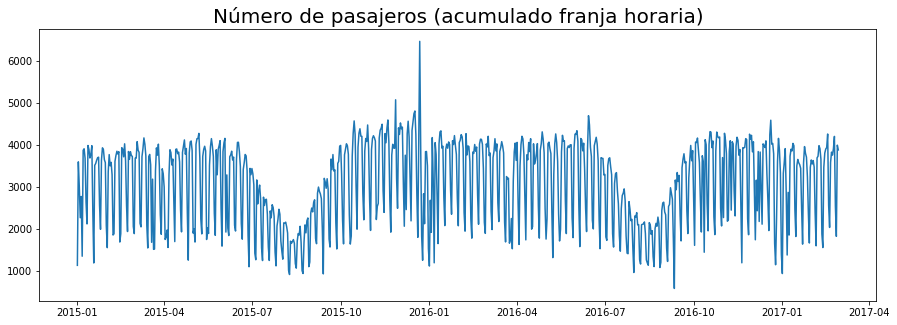

In [15]:
plt.figure(figsize=(15,5))
plt.plot(fechas, target)
plt.title('Número de pasajeros (acumulado franja horaria)', fontsize=20);

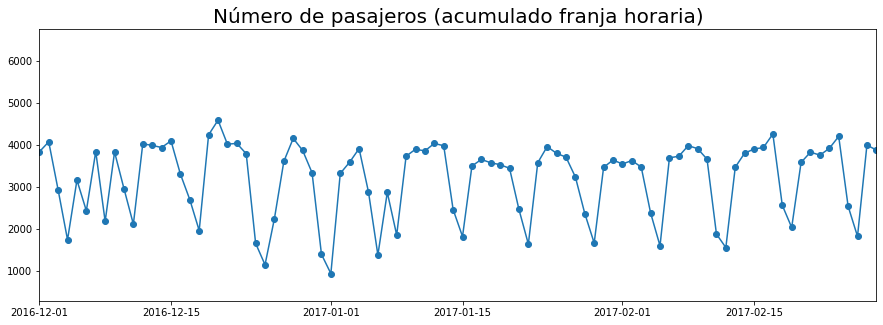

In [16]:
plt.figure(figsize=(15,5))
plt.plot(fechas, target, 'o-')
plt.title('Número de pasajeros (acumulado franja horaria)', fontsize=20)
plt.xlim([fechas[-90],fechas[-1]]);

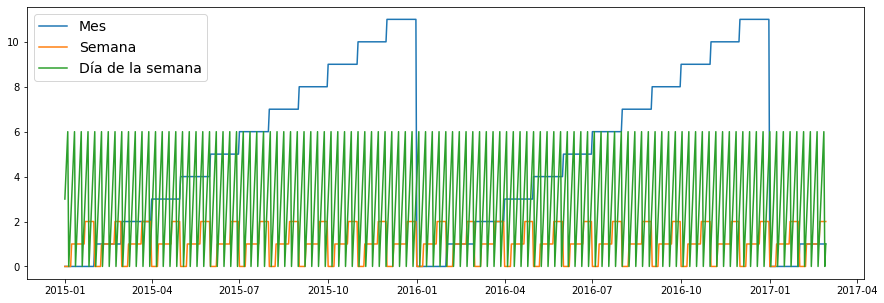

In [17]:
plt.figure(figsize=(15,5))
plt.plot(fechas, mes, label='Mes')
plt.plot(fechas, semana, label='Semana')
plt.plot(fechas, day_of_week, label='Día de la semana')
plt.legend(fontsize=14);

Media número de viajeros    : 3065.5784810126584


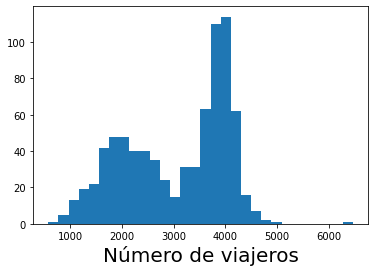

In [18]:
plt.hist(target, bins=30)
plt.xlabel('Número de viajeros', fontsize=20)
print("Media número de viajeros    :", target.mean())

## <font color="#CA3532"> **4. Transformación de la variable a predecir**

In [19]:
# Transformación de escala (ajustar el factor en función del problema)
def transform(x):
    return x/5000
def inverse_transform(x_escalado):
    return x_escalado*5000

In [20]:
transform(np.array([1,2,3]))

array([0.0002, 0.0004, 0.0006])

## <font color="#CA3532"> **5. Enventanado de datos**

In [21]:
from my_utils_series_temporales import enventanar, info_enventanado, NAN

In [22]:
target_transf = transform(target)

# series: variables en las que no quiero realizar embeddings
series          = [target_transf, festivo]
se_saben_antes  = [False, True]
nombres_series  = ["target_transf", "festivo"]


series2         = [mes]
se_saben_antes2 = [True]
nombres_series2 = ["mes"]

series3         = [semana]
se_saben_antes3 = [True]
nombres_series3 = ["semana"]

series4         = [day_of_week]
se_saben_antes4 = [True]
nombres_series4 = ["day_of_week"]

Hago 4 enventanados ahora porque no va a haber una sola entrada al modelo, habrán 4.

In [23]:
print(np.shape(series))
print(np.shape(se_saben_antes))

print(np.shape(series2))
print(np.shape(se_saben_antes2))

print(np.shape(series3))
print(np.shape(se_saben_antes3))

print(np.shape(series4))
print(np.shape(se_saben_antes4))

(2, 790)
(2,)
(1, 790)
(1,)
(1, 790)
(1,)
(1, 790)
(1,)


In [24]:
lookback = 5 # lookback es otro sinónimo de W_in

# target=0 en siguiente línea quiere decir cuál es el índice del target en objeto "series":
X, y  = enventanar(series, target=0, se_saben_antes=se_saben_antes,
                   W_in=lookback)

X2, _ = enventanar(series2, target=0, se_saben_antes=se_saben_antes2,
                   W_in=lookback)

X3, _ = enventanar(series3, target=0, se_saben_antes=se_saben_antes3,
                   W_in=lookback)

X4, _ = enventanar(series4, target=0, se_saben_antes=se_saben_antes4,
                   W_in=lookback)

print(X.shape, np.shape(y))
print(X2.shape, X3.shape, X4.shape)

(790, 5, 2) (790,)
(790, 5, 1) (790, 5, 1) (790, 5, 1)


In [25]:
info_enventanado(X[:10],y[:10],
                 nombres_series=nombres_series,
                 nombre_target="target_transf",
                 tiempos=fechas)

10 ventanas creadas

X.shape=(10, 5, 2)  Y.shape=(10,) 

 Ventana 0: 


X[0].shape=(5, 2) ?0 ?1 ?2 ?3 ?4 
 
 target_transf 
 nan 
 nan 
 nan 
 nan 
 nan 
 
 
 festivo 
 nan 
 nan 
 nan 
 nan 
 1.000000 
 
 __ Y[0]=0.225 2015-01-01 00:00:00 
 
 target_transf 
 0.225000

 Ventana 1: 


X[1].shape=(5, 2) ?0 ?1 ?2 ?3 2015-01-01T00:00:00.000000000 
 
 target_transf 
 nan 
 nan 
 nan 
 nan 
 0.225000 
 
 
 festivo 
 nan 
 nan 
 nan 
 1.000000 
 0.000000 
 
 __ Y[1]=0.7184 2015-01-02 00:00:00 
 
 target_transf 
 0.718400

 Ventana 2: 


X[2].shape=(5, 2) ?0 ?1 ?2 2015-01-01T00:00:00.000000000 2015-01-02T00:00:00.000000000 
 
 target_transf 
 nan 
 nan 
 nan 
 0.225000 
 0.718400 
 
 
 festivo 
 nan 
 nan 
 1.000000 
 0.000000 
 0.000000 
 
 __ Y[2]=0.6002 2015-01-03 00:00:00 
 
 target_transf 
 0.600200

 Ventana 3: 


X[3].shape=(5, 2) ?0 ?1 2015-01-01T00:00:00.000000000 2015-01-02T00:00:00.000000000 2015-01-03T00:00:00.000000000 
 
 target_transf 
 nan 
 nan 
 0.225000 
 0.718400 
 0.600200 
 
 
 festivo 
 nan 
 1.000000 
 0.000000 
 0.000000 
 0.000000 
 
 __ Y[3]=0.452 2015-01-04 00:00:00 
 
 target_transf 
 0.452000

 Ventana 4: 


X[4].shape=(5, 2) ?0 2015-01-01T00:00:00.000000000 2015-01-02T00:00:00.000000000 2015-01-03T00:00:00.000000000 2015-01-04T00:00:00.000000000 
 
 target_transf 
 nan 
 0.225000 
 0.718400 
 0.600200 
 0.452000 
 
 
 festivo 
 1.000000 
 0.000000 
 0.000000 
 0.000000 
 0.000000 
 
 __ Y[4]=0.5534 2015-01-05 00:00:00 
 
 target_transf 
 0.553400

 Ventana 5: 


X[5].shape=(5, 2) 2015-01-01 00:00:00 2015-01-02 00:00:00 2015-01-03 00:00:00 2015-01-04 00:00:00 2015-01-05 00:00:00 
 
 target_transf 
 0.225000 
 0.718400 
 0.600200 
 0.452000 
 0.553400 
 
 
 festivo 
 0.000000 
 0.000000 
 0.000000 
 0.000000 
 1.000000 
 
 __ Y[5]=0.2684 2015-01-06 00:00:00 
 
 target_transf 
 0.268400

 Ventana 6: 


X[6].shape=(5, 2) 2015-01-02 00:00:00 2015-01-03 00:00:00 2015-01-04 00:00:00 2015-01-05 00:00:00 2015-01-06 00:00:00 
 
 target_transf 
 0.718400 
 0.600200 
 0.452000 
 0.553400 
 0.268400 
 
 
 festivo 
 0.000000 
 0.000000 
 0.000000 
 1.000000 
 0.000000 
 
 __ Y[6]=0.7734 2015-01-07 00:00:00 
 
 target_transf 
 0.773400

 Ventana 7: 


X[7].shape=(5, 2) 2015-01-03 00:00:00 2015-01-04 00:00:00 2015-01-05 00:00:00 2015-01-06 00:00:00 2015-01-07 00:00:00 
 
 target_transf 
 0.600200 
 0.452000 
 0.553400 
 0.268400 
 0.773400 
 
 
 festivo 
 0.000000 
 0.000000 
 1.000000 
 0.000000 
 0.000000 
 
 __ Y[7]=0.7808 2015-01-08 00:00:00 
 
 target_transf 
 0.780800

 Ventana 8: 


X[8].shape=(5, 2) 2015-01-04 00:00:00 2015-01-05 00:00:00 2015-01-06 00:00:00 2015-01-07 00:00:00 2015-01-08 00:00:00 
 
 target_transf 
 0.452000 
 0.553400 
 0.268400 
 0.773400 
 0.780800 
 
 
 festivo 
 0.000000 
 1.000000 
 0.000000 
 0.000000 
 0.000000 
 
 __ Y[8]=0.7356 2015-01-09 00:00:00 
 
 target_transf 
 0.735600

 Ventana 9: 


X[9].shape=(5, 2) 2015-01-05 00:00:00 2015-01-06 00:00:00 2015-01-07 00:00:00 2015-01-08 00:00:00 2015-01-09 00:00:00 
 
 target_transf 
 0.553400 
 0.268400 
 0.773400 
 0.780800 
 0.735600 
 
 
 festivo 
 1.000000 
 0.000000 
 0.000000 
 0.000000 
 0.000000 
 
 __ Y[9]=0.5262 2015-01-10 00:00:00 
 
 target_transf 
 0.526200

In [26]:
info_enventanado(X2[:10],y[:10],
                 nombres_series=nombres_series2,
                 nombre_target="target_transf",
                 tiempos=fechas)

10 ventanas creadas

X.shape=(10, 5, 1)  Y.shape=(10,) 

 Ventana 0: 


X[0].shape=(5, 1) ?0 ?1 ?2 ?3 ?4 
 
 mes 
 nan 
 nan 
 nan 
 nan 
 0.000000 
 
 __ Y[0]=0.225 2015-01-01 00:00:00 
 
 target_transf 
 0.225000

 Ventana 1: 


X[1].shape=(5, 1) ?0 ?1 ?2 ?3 2015-01-01T00:00:00.000000000 
 
 mes 
 nan 
 nan 
 nan 
 0.000000 
 0.000000 
 
 __ Y[1]=0.7184 2015-01-02 00:00:00 
 
 target_transf 
 0.718400

 Ventana 2: 


X[2].shape=(5, 1) ?0 ?1 ?2 2015-01-01T00:00:00.000000000 2015-01-02T00:00:00.000000000 
 
 mes 
 nan 
 nan 
 0.000000 
 0.000000 
 0.000000 
 
 __ Y[2]=0.6002 2015-01-03 00:00:00 
 
 target_transf 
 0.600200

 Ventana 3: 


X[3].shape=(5, 1) ?0 ?1 2015-01-01T00:00:00.000000000 2015-01-02T00:00:00.000000000 2015-01-03T00:00:00.000000000 
 
 mes 
 nan 
 0.000000 
 0.000000 
 0.000000 
 0.000000 
 
 __ Y[3]=0.452 2015-01-04 00:00:00 
 
 target_transf 
 0.452000

 Ventana 4: 


X[4].shape=(5, 1) ?0 2015-01-01T00:00:00.000000000 2015-01-02T00:00:00.000000000 2015-01-03T00:00:00.000000000 2015-01-04T00:00:00.000000000 
 
 mes 
 0.000000 
 0.000000 
 0.000000 
 0.000000 
 0.000000 
 
 __ Y[4]=0.5534 2015-01-05 00:00:00 
 
 target_transf 
 0.553400

 Ventana 5: 


X[5].shape=(5, 1) 2015-01-01 00:00:00 2015-01-02 00:00:00 2015-01-03 00:00:00 2015-01-04 00:00:00 2015-01-05 00:00:00 
 
 mes 
 0.000000 
 0.000000 
 0.000000 
 0.000000 
 0.000000 
 
 __ Y[5]=0.2684 2015-01-06 00:00:00 
 
 target_transf 
 0.268400

 Ventana 6: 


X[6].shape=(5, 1) 2015-01-02 00:00:00 2015-01-03 00:00:00 2015-01-04 00:00:00 2015-01-05 00:00:00 2015-01-06 00:00:00 
 
 mes 
 0.000000 
 0.000000 
 0.000000 
 0.000000 
 0.000000 
 
 __ Y[6]=0.7734 2015-01-07 00:00:00 
 
 target_transf 
 0.773400

 Ventana 7: 


X[7].shape=(5, 1) 2015-01-03 00:00:00 2015-01-04 00:00:00 2015-01-05 00:00:00 2015-01-06 00:00:00 2015-01-07 00:00:00 
 
 mes 
 0.000000 
 0.000000 
 0.000000 
 0.000000 
 0.000000 
 
 __ Y[7]=0.7808 2015-01-08 00:00:00 
 
 target_transf 
 0.780800

 Ventana 8: 


X[8].shape=(5, 1) 2015-01-04 00:00:00 2015-01-05 00:00:00 2015-01-06 00:00:00 2015-01-07 00:00:00 2015-01-08 00:00:00 
 
 mes 
 0.000000 
 0.000000 
 0.000000 
 0.000000 
 0.000000 
 
 __ Y[8]=0.7356 2015-01-09 00:00:00 
 
 target_transf 
 0.735600

 Ventana 9: 


X[9].shape=(5, 1) 2015-01-05 00:00:00 2015-01-06 00:00:00 2015-01-07 00:00:00 2015-01-08 00:00:00 2015-01-09 00:00:00 
 
 mes 
 0.000000 
 0.000000 
 0.000000 
 0.000000 
 0.000000 
 
 __ Y[9]=0.5262 2015-01-10 00:00:00 
 
 target_transf 
 0.526200

In [27]:
print(X.shape, X2.shape, X3.shape, X4.shape)
print(np.shape(target))

(790, 5, 2) (790, 5, 1) (790, 5, 1) (790, 5, 1)
(790,)


## <font color="#CA3532"> **6. Separación training-test**

In [28]:
train_perc  = .8
punto_corte = int(len(X)*train_perc)

In [29]:
target_train = target[lookback:punto_corte]
X_train  = X[lookback:punto_corte]
X2_train = X2[lookback:punto_corte]
X3_train = X3[lookback:punto_corte]
X4_train = X4[lookback:punto_corte]
y_train = y[lookback:punto_corte]
fechas_train = fechas[lookback:punto_corte]

target_test  = target[punto_corte:]
X_test   = X[punto_corte:]
X2_test  = X2[punto_corte:]
X3_test  = X3[punto_corte:]
X4_test  = X4[punto_corte:]
y_test  = y[punto_corte:]
fechas_test      = fechas[punto_corte:]

print(np.shape(target_train))
print(np.shape(target_test))

(627,)
(158,)


In [30]:
print(X_train.shape, X2_train.shape, X3_train.shape, X4_train.shape, y_train.shape)

(627, 5, 2) (627, 5, 1) (627, 5, 1) (627, 5, 1) (627,)


## <font color="#CA3532"> **7. Construcción del modelo con Keras**

In [31]:
from keras.models import Sequential, load_model
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten
from keras.layers import Input, Embedding, concatenate
from keras.callbacks import ModelCheckpoint
from keras import Model
from keras import optimizers

In [32]:
# número de variables con las que codifico cada variable categórica
# (en este caso son todas 2 por simplicidad, pero no tiene por qué)
dim_embedding_mes         = 2
dim_embedding_semana      = 2
dim_embedding_day_of_week = 2

input1 = Input(shape=(lookback, X_train.shape[2]), name="input1")

input2 = Input(shape=(lookback), name="mes")

# embedding de mes: hay 12 categorías (valores: 0-11)
embedding2 = Embedding(input_dim=12, output_dim=dim_embedding_mes, # input_dim: número de categorías
                       input_length=lookback, name="embedding_mes")(input2)

# embedding de semana: hay 3 categorías (valores: 0-2)
input3 = Input(shape=(lookback), name="semana")
embedding3 = Embedding(input_dim=3, output_dim=dim_embedding_semana, # input_dim: número de categorías
                       input_length=lookback, name="embedding_semana")(input3)

# embedding de day_of_week: hay 7 categorías (valores: 0-6)
input4 = Input(shape=(lookback), name="day_of_week")
embedding4 = Embedding(input_dim=7, output_dim=dim_embedding_day_of_week, # input_dim: número de categorías
                       input_length=lookback, name="embedding_day_of_week")(input4)

x = concatenate([input1, embedding2, embedding3, embedding4])

x = Conv1D(4, kernel_size=3, activation="relu")(x)
x = Conv1D(4, kernel_size=3, activation="relu")(x)
x = Flatten()(x)
x = Dense(8, activation="relu")(x)

x = Dense(1)(x)

model = Model(inputs=[input1, input2, input3, input4], outputs=x)

model.compile(loss='mean_squared_error',
              optimizer='adam',
              #optimizer=Adam(learning_rate=0.01), # más rápido
              metrics=['mse']) # 'RMSprop'
# mean_absolute_error

import keras.backend as K
print(K.get_value(model.optimizer.lr))

0.001


La capa de embedding decide como mapear(codificar) los datos en el espacio 2D.
Lo hacemos para día, mes y semana por separado. Luego se añaden las variables numéricas (concatena) y obtiene un vector de 8 componentes. 

Lo inteligente es codificar meses donde suceden cosas parecidas de manera similar.

In [33]:
model.optimizer.lr

<tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.001>

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 mes (InputLayer)               [(None, 5)]          0           []                               
                                                                                                  
 semana (InputLayer)            [(None, 5)]          0           []                               
                                                                                                  
 day_of_week (InputLayer)       [(None, 5)]          0           []                               
                                                                                                  
 input1 (InputLayer)            [(None, 5, 2)]       0           []                               
                                                                                              

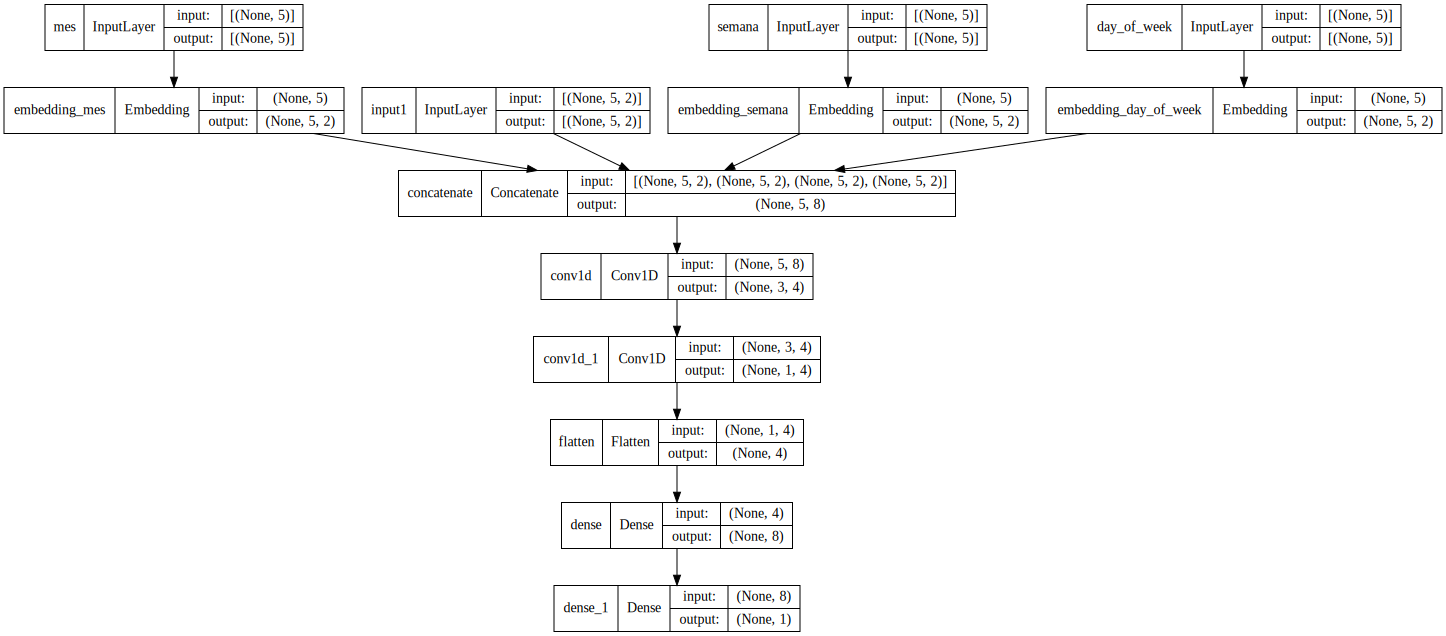

In [34]:
model.summary()

from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
if COLAB:
    display(SVG(model_to_dot(model,show_shapes=True,dpi=72).create(prog='dot', format='svg')))
else:
    display(SVG(model_to_dot(model,show_shapes=True).create(prog='dot', format='svg')))

In [35]:
def grafica_entrenamiento(tr_mse, val_mse):
    ax=plt.figure(figsize=(10,4)).gca()
    plt.plot(1+np.arange(len(tr_mse)), tr_mse)
    plt.plot(1+np.arange(len(val_mse)), val_mse)
    plt.title('mse del modelo', fontsize=18)
    plt.xlabel('epoca', fontsize=18)
    plt.ylabel('mse', fontsize=18)
    plt.legend(['entrenamiento', 'validación'], loc='upper left')
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    plt.show()


Epoch 00001: val_mse improved from inf to 0.35283, saving model to model_current_best.h5

Epoch 00001: val_mse improved from 0.35283 to 0.33254, saving model to model_current_best.h5

Epoch 00001: val_mse improved from 0.33254 to 0.30230, saving model to model_current_best.h5

Epoch 00001: val_mse improved from 0.30230 to 0.25517, saving model to model_current_best.h5

Epoch 00001: val_mse improved from 0.25517 to 0.18132, saving model to model_current_best.h5

Epoch 00001: val_mse improved from 0.18132 to 0.10246, saving model to model_current_best.h5

Epoch 00001: val_mse improved from 0.10246 to 0.05088, saving model to model_current_best.h5

Epoch 00001: val_mse improved from 0.05088 to 0.03333, saving model to model_current_best.h5

Epoch 00001: val_mse did not improve from 0.03333

Epoch 00001: val_mse improved from 0.03333 to 0.03217, saving model to model_current_best.h5

Epoch 00001: val_mse improved from 0.03217 to 0.02635, saving model to model_current_best.h5

Epoch 00001:

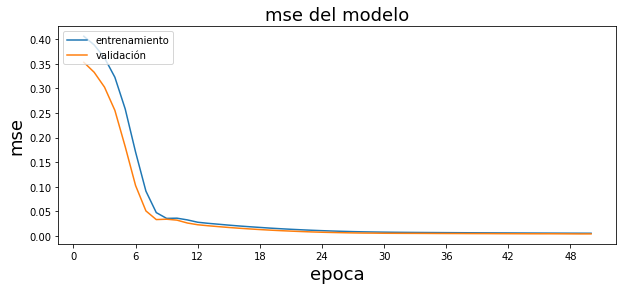


Epoch 00001: val_mse did not improve from 0.00420

Epoch 00001: val_mse improved from 0.00420 to 0.00417, saving model to model_current_best.h5

Epoch 00001: val_mse improved from 0.00417 to 0.00402, saving model to model_current_best.h5

Epoch 00001: val_mse did not improve from 0.00402

Epoch 00001: val_mse improved from 0.00402 to 0.00400, saving model to model_current_best.h5

Epoch 00001: val_mse improved from 0.00400 to 0.00392, saving model to model_current_best.h5

Epoch 00001: val_mse improved from 0.00392 to 0.00389, saving model to model_current_best.h5

Epoch 00001: val_mse did not improve from 0.00389

Epoch 00001: val_mse improved from 0.00389 to 0.00383, saving model to model_current_best.h5

Epoch 00001: val_mse did not improve from 0.00383

Epoch 00001: val_mse improved from 0.00383 to 0.00374, saving model to model_current_best.h5

Epoch 00001: val_mse did not improve from 0.00374

Epoch 00001: val_mse did not improve from 0.00374

Epoch 00001: val_mse improved from 

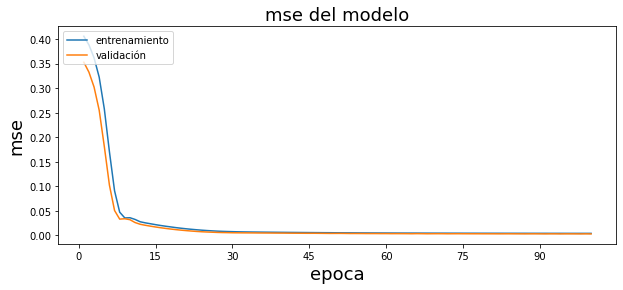


Epoch 00001: val_mse did not improve from 0.00319

Epoch 00001: val_mse did not improve from 0.00319

Epoch 00001: val_mse did not improve from 0.00319

Epoch 00001: val_mse did not improve from 0.00319

Epoch 00001: val_mse did not improve from 0.00319

Epoch 00001: val_mse improved from 0.00319 to 0.00318, saving model to model_current_best.h5

Epoch 00001: val_mse did not improve from 0.00318

Epoch 00001: val_mse improved from 0.00318 to 0.00310, saving model to model_current_best.h5

Epoch 00001: val_mse did not improve from 0.00310

Epoch 00001: val_mse did not improve from 0.00310

Epoch 00001: val_mse did not improve from 0.00310

Epoch 00001: val_mse improved from 0.00310 to 0.00301, saving model to model_current_best.h5

Epoch 00001: val_mse did not improve from 0.00301

Epoch 00001: val_mse did not improve from 0.00301

Epoch 00001: val_mse did not improve from 0.00301

Epoch 00001: val_mse did not improve from 0.00301

Epoch 00001: val_mse did not improve from 0.00301

Epo

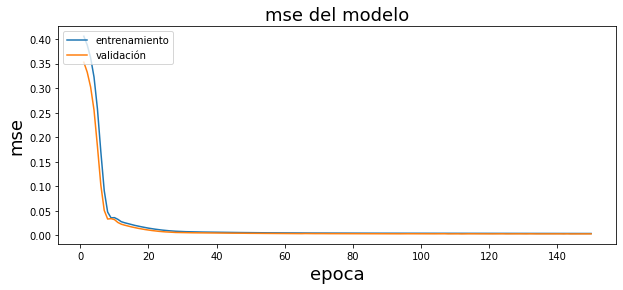


Epoch 00001: val_mse improved from 0.00299 to 0.00292, saving model to model_current_best.h5

Epoch 00001: val_mse did not improve from 0.00292

Epoch 00001: val_mse did not improve from 0.00292

Epoch 00001: val_mse did not improve from 0.00292

Epoch 00001: val_mse did not improve from 0.00292

Epoch 00001: val_mse improved from 0.00292 to 0.00289, saving model to model_current_best.h5

Epoch 00001: val_mse did not improve from 0.00289

Epoch 00001: val_mse did not improve from 0.00289

Epoch 00001: val_mse did not improve from 0.00289

Epoch 00001: val_mse did not improve from 0.00289

Epoch 00001: val_mse did not improve from 0.00289

Epoch 00001: val_mse did not improve from 0.00289

Epoch 00001: val_mse did not improve from 0.00289

Epoch 00001: val_mse did not improve from 0.00289

Epoch 00001: val_mse did not improve from 0.00289

Epoch 00001: val_mse did not improve from 0.00289

Epoch 00001: val_mse did not improve from 0.00289

Epoch 00001: val_mse improved from 0.00289 to 

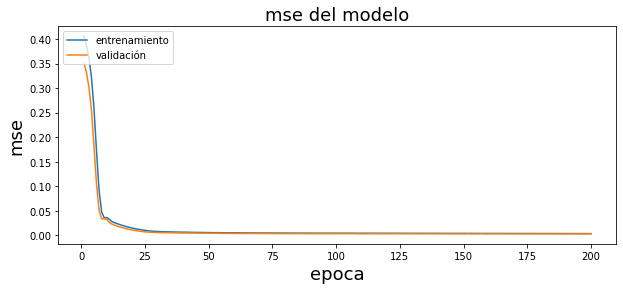

In [ ]:
epochs = 200
batch_size = 64
Nval = 200
control_sobreajuste_val = True

if not control_sobreajuste_val:
    history = model.fit(X_train, y_train, epochs=epochs,
                        batch_size=batch_size, verbose=2)
else:    
    acum_tr_mse = []
    acum_val_mse = []

    Xs_val = {"input1":X_train[-Nval:], "mes":X2_train[-Nval:], "semana":X3_train[-Nval:], "day_of_week":X4_train[-Nval:]}
    y_val  = y_train[-Nval:]

    modelpath="model_current_best.h5"
    checkpoint = ModelCheckpoint(modelpath, monitor='val_mse', verbose=2, # val_mean_squared_error
                                 save_best_only=True,
                                 mode='min') # graba sólo los que mejoran en validación

    callbacks_list = [checkpoint]
    
    for e in range(epochs):
        #aux = aug.scaling(aug.jitter(X_train[:-Nval])) # data augmentation con jitter
        aux = X_train[:-Nval]
        history = model.fit({"input1":aux, "mes":X2_train[:-Nval], "semana":X3_train[:-Nval], "day_of_week":X4_train[:-Nval]},
                            y_train[:-Nval],
                            batch_size=batch_size,
                            epochs=1,
                            callbacks=callbacks_list,
                            verbose=0,
                            validation_data=(Xs_val, y_val))
        
        acum_tr_mse  += history.history['mse'] # mean_squared_error
        acum_val_mse += history.history['val_mse'] # val_mean_squared_error
        
        if (e+1)%50 == 0:
            grafica_entrenamiento(acum_tr_mse, acum_val_mse)

In [ ]:
model = load_model(modelpath) # recupero el mejor modelo en validación

## <font color="#CA3532"> **8. Chequeo del modelo (predicción a un día)**

In [36]:
y_train_prediction = model.predict({"input1":X_train, "mes":X2_train, "semana":X3_train, "day_of_week":X4_train}).flatten()
y_test_prediction = model.predict({"input1":X_test, "mes":X2_test, "semana":X3_test, "day_of_week":X4_test}).flatten()

In [37]:
target_train_pred = inverse_transform(y_train_prediction)
target_test_pred  = inverse_transform(y_test_prediction)

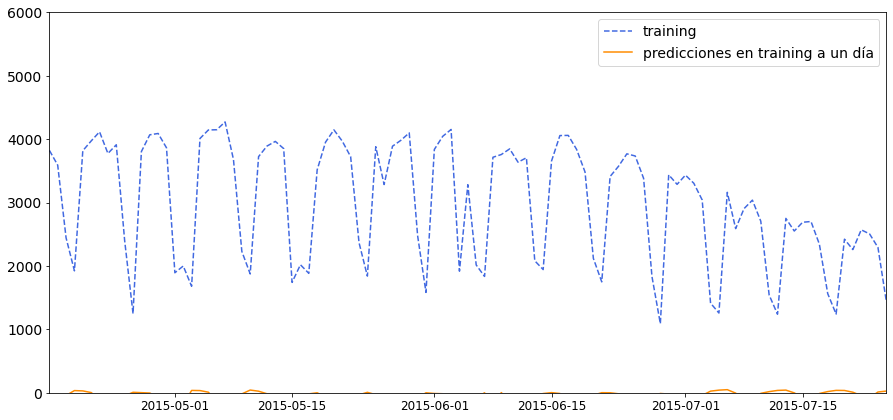

In [38]:
plt.figure(figsize=(15,7))
plt.plot(fechas_train, target_train, '--', c='royalblue',
         label="training")
plt.plot(fechas_train, target_train_pred,  c='darkorange',
         label="predicciones en training a un día")

plt.xticks(fontsize=12)
plt.yticks(fontsize=14)
plt.axis([fechas_train[100],fechas_train[200],0,6000])
plt.legend(fontsize=14);

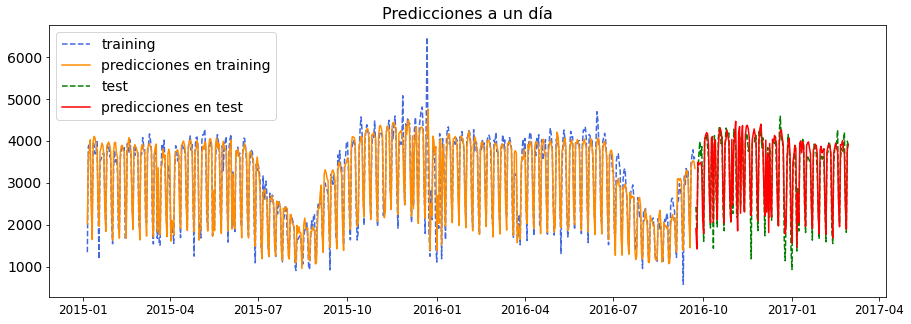

In [ ]:
plt.figure(figsize=(15,5))
plt.plot(fechas_train, target_train, '--', c='royalblue',
         label='training')
plt.plot(fechas_train, target_train_pred,  c='darkorange',
         label='predicciones en training')
plt.plot(fechas_test, target_test, '--',   c='green',
         label='test')
plt.plot(fechas_test, target_test_pred,    c='red',
         label='predicciones en test')
plt.xticks(fontsize=12)
plt.yticks(fontsize=14)
plt.title('Predicciones a un día', fontsize=16)
plt.legend(fontsize=14);

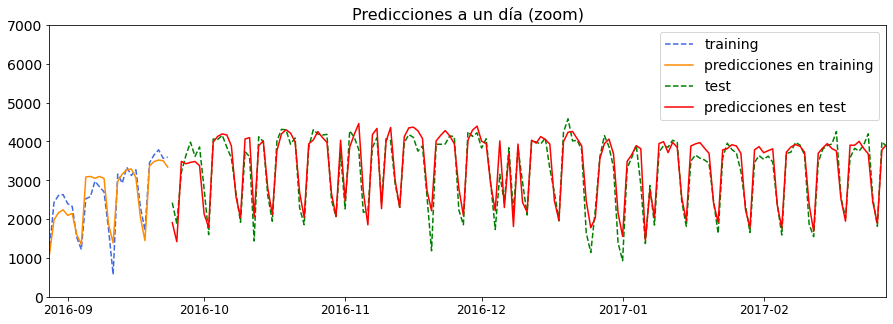

In [ ]:
plt.figure(figsize=(15,5))
plt.plot(fechas_train, target_train, '--', c='royalblue',
         label='training')
plt.plot(fechas_train, target_train_pred,  c='darkorange',
         label='predicciones en training')
plt.plot(fechas_test, target_test, '--',   c='green',
         label='test')
plt.plot(fechas_test, target_test_pred,    c='red',
         label='predicciones en test')
plt.title('Predicciones a un día (zoom)', fontsize=16)
plt.legend(fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=14)
plt.axis([fechas_train[600],fechas_test[-1],0,7000]);

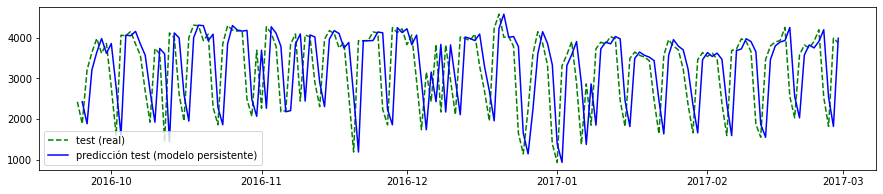

In [ ]:
plt.figure(figsize=(15,3))
plt.plot(fechas_test, target_test, '--',   c='green',
         label='test (real)')
plt.plot(fechas_test[1:], target_test[:-1], '-',   c='blue',
         label='predicción test (modelo persistente)')
plt.legend();

In [ ]:
# Modelos de referencia (en orden de complejidad):
# 1- Predecir siempre media (mediana) en training
# 2- Modelo persistente (a 1 día, 7 días etc.)
# 3- SARIMAX


# R2 scores
print("R2 del modelo en training      : ",
      R2_score(target_train[1:], target_train_pred[1:]))
print("R2 del modelo en test          : ",
      R2_score(target_test, target_test_pred))
print("R2 modelo persistente 1 día    : ",
      R2_score(target_test[1:], target_test[:-1]))
print("R2 modelo persistente 1 semana : ",
      R2_score(target_test[7:], target_test[:-7]))
print("R2 modelo persistente 4 semanas: ",
      R2_score(target_test[28:], target_test[:-28]))
print("R2 modelo persistente 1 año: ",
      R2_score(target_train[7*52:], target_train[:-7*52]))

R2 del modelo en training      :  0.9167475551711143
R2 del modelo en test          :  0.8846722981423812
R2 modelo persistente 1 día    :  -0.44768351889101354
R2 modelo persistente 1 semana :  0.3743300534633949
R2 modelo persistente 4 semanas:  0.48525679455105053
R2 modelo persistente 1 año:  0.6779203301147232


In [ ]:
# RMSEs
sqrt = np.sqrt
print("RMSE del modelo en training      : ",
      sqrt(mean_squared_error(target_train[1:],
                              target_train_pred[1:])))
print("RMSE del modelo en test          : ",
      sqrt(mean_squared_error(target_test,
                              target_test_pred)))
print("RMSE modelo persistente 1 día    : ",
      sqrt(mean_squared_error(target_test[1:],
                              target_test[:-1])))
print("RMSE modelo persistente 1 semana : ",
      sqrt(mean_squared_error(target_test[7:],
                              target_test[:-7])))
print("RMSE modelo persistente 4 semanas: ",
      sqrt(mean_squared_error(target_test[28:],
                              target_test[:-28])))

RMSE del modelo en training      :  291.33076590499496
RMSE del modelo en test          :  308.5941945037845
RMSE modelo persistente 1 día    :  1093.8023843688381
RMSE modelo persistente 1 semana :  724.5713553588926
RMSE modelo persistente 4 semanas:  654.1568971996292


### Análisis de los embeddings construidos

In [39]:
embeddings_mes = model.get_layer("embedding_mes").get_weights()[0]
embeddings_mes.shape

(12, 2)

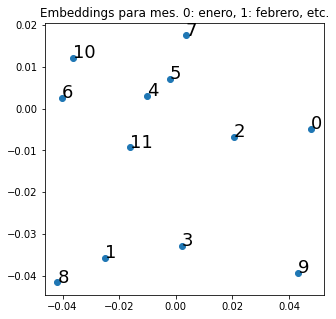

In [40]:
plt.figure(figsize=(5,5))
plt.plot(embeddings_mes[:,0], embeddings_mes[:,1], "o")
for i,coords in enumerate(embeddings_mes):
    plt.text(coords[0],coords[1],i, fontsize=18)
plt.title("Embeddings para mes. 0: enero, 1: febrero, etc.");

Esta es la codificación mejor para la red.

In [ ]:
embeddings_semana = model.get_layer("embedding_semana").get_weights()[0]
embeddings_semana.shape

(3, 2)

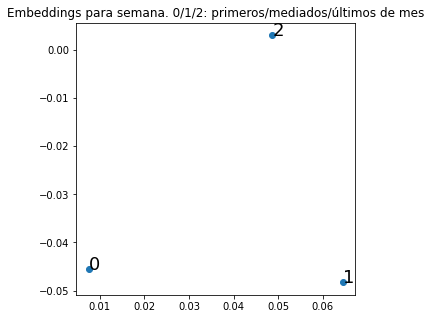

In [ ]:
plt.figure(figsize=(5,5))
plt.plot(embeddings_semana[:,0], embeddings_semana[:,1], "o")
for i,coords in enumerate(embeddings_semana):
    a = plt.text(coords[0],coords[1],i, fontsize=18)
plt.title("Embeddings para semana. 0/1/2: primeros/mediados/últimos de mes");

In [ ]:
embeddings_day_of_week = model.get_layer("embedding_day_of_week").get_weights()[0]
embeddings_day_of_week.shape

(7, 2)

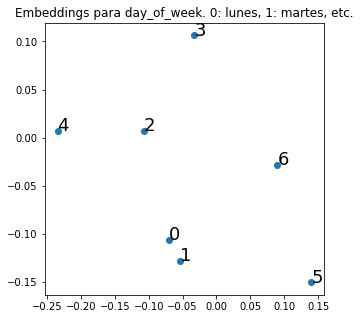

In [ ]:
plt.figure(figsize=(5,5))
plt.plot(embeddings_day_of_week[:,0], embeddings_day_of_week[:,1], "o")
for i,coords in enumerate(embeddings_day_of_week):
    plt.text(coords[0],coords[1],i, fontsize=18)
plt.title("Embeddings para day_of_week. 0: lunes, 1: martes, etc.");